# SVD Evaluation Module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split


In [2]:
import recmetrics

# Dataset Prep

In [3]:
ratings = pd.read_pickle('../data/processed_data.pkl')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [4]:
#only consider ratings from users who have rated over n recipes
n=1000
users = ratings["user_id"].value_counts()
users = users[users>n].index.tolist()

In [5]:
ratings = ratings.query('user_id in @users')
print(ratings.shape)
ratings.head(3)

(133653, 4)


,rating,name,user_id,recipe_id
2,5,baked potato toppings,14502,34897
34,5,potato crab chowder,11533,32625
78,4,honey glazed baby carrots,31330,82227


## Get features

In [6]:
rated_recipes = ratings["recipe_id"].tolist()

recipes = pd.read_csv('../data/recipes.csv')
recipes = recipes.query('id in @rated_recipes')
recipes.set_index("id", inplace=True, drop=True)

recipes = recipes["tags"].str.strip('][').str.split(", ", expand=True)
recipes.reset_index(inplace=True)

recipes = pd.melt(recipes, id_vars='id', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

recipes.drop_duplicates("id", inplace=True)
recipes.set_index('id', inplace=True)

recipes = pd.get_dummies(recipes.value)
recipes.head()



,'','15-minutes-or-less','30-minutes-or-less','60-minutes-or-less','bacon','celebrity','curries','danish','ham','lactose','oysters','time-to-make','weeknight'
id,,,,,,,,,,,,,
137739,0,0,0,1,0,0,0,0,0,0,0,0,0
31490,0,0,1,0,0,0,0,0,0,0,0,0,0
44061,0,0,0,0,0,0,0,0,0,0,0,0,1
25274,0,1,0,0,0,0,0,0,0,0,0,0,0
67888,0,0,0,0,0,0,0,0,0,0,0,0,1


## Long Tail Plot Example

/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


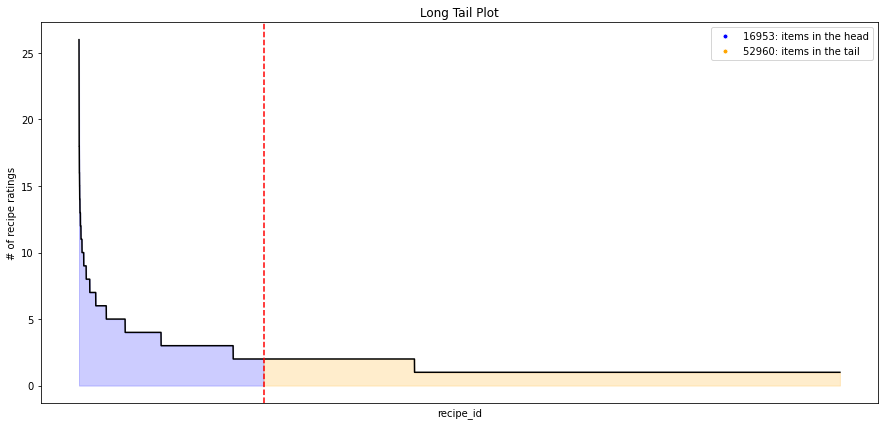

In [7]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="recipe_id", 
             interaction_type="recipe ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

## Format data for Surprise

In [8]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'recipe_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

## Train SVD Recommender

In [9]:
algo = SVD()
algo.fit(trainset)

## Make predictions on SVD test set

In [10]:
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'recipe_id', 'actual', 'cf_predictions']
test.head()

,user_id,recipe_id,actual,cf_predictions
0,53653,132341,5.0,4.866260
1,215,1915,5.0,4.780356
2,5947,85022,5.0,4.729881
3,19617,111855,5.0,4.680790
4,10002,51591,5.0,4.578207


## Evaluate model with MSE and RMSE

In [11]:
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.16460322310262412
RMSE:  0.40571322766533524


In [12]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='user_id', columns='recipe_id', values='cf_predictions').fillna(0)

In [13]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [14]:
#get example prediction
get_users_predictions(25281, 10, cf_model)

[44534, 123688, 82538, 36208, 23234, 47610, 55456, 77072, 16050, 34053]

In [15]:
get_users_predictions(31330, 10, cf_model)

[108099, 80852, 102061, 121932, 99879, 42407, 52734, 92310, 1583, 136128]

In [16]:
test = test.copy().groupby('user_id', as_index=False)['recipe_id'].agg({'actual': (lambda x: list(set(x)))})

In [17]:
test = test.set_index("user_id")

In [18]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
user_id,,
178,"[24576, 53255, 49162, 12299, 2058, 26638, 1126...","[57155, 49681, 74363, 28291, 21942, 71255, 695..."
215,"[8195, 24586, 12299, 65552, 6160, 71708, 53276...","[76204, 71708, 56866, 58465, 49026, 23057, 275..."
351,"[45057, 25601, 38403, 3076, 39946, 6156, 42511...","[11624, 18546, 34505, 61282, 14150, 29425, 374..."
531,"[79880, 12299, 10253, 8207, 24595, 51221, 7171...","[12400, 56270, 76992, 40650, 5539, 76043, 4834..."
617,"[40963, 52227, 10243, 8198, 48647, 38409, 3021...","[2879, 12213, 81217, 77601, 21637, 33449, 4236..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 recipes to every user.

In [19]:
#make recommendations for all members in the test data
popularity_recs = ratings.recipe_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
user_id,,,
178,"[24576, 53255, 49162, 12299, 2058, 26638, 1126...","[57155, 49681, 74363, 28291, 21942, 71255, 695...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
215,"[8195, 24586, 12299, 65552, 6160, 71708, 53276...","[76204, 71708, 56866, 58465, 49026, 23057, 275...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
351,"[45057, 25601, 38403, 3076, 39946, 6156, 42511...","[11624, 18546, 34505, 61282, 14150, 29425, 374...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
531,"[79880, 12299, 10253, 8207, 24595, 51221, 7171...","[12400, 56270, 76992, 40650, 5539, 76043, 4834...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
617,"[40963, 52227, 10243, 8198, 48647, 38409, 3021...","[2879, 12213, 81217, 77601, 21637, 33449, 4236...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random recipes to every user.

In [20]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.recipe_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
user_id,,,,
178,"[24576, 53255, 49162, 12299, 2058, 26638, 1126...","[57155, 49681, 74363, 28291, 21942, 71255, 695...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[43738, 129864, 114045, 53829, 87695, 40309, 4..."
215,"[8195, 24586, 12299, 65552, 6160, 71708, 53276...","[76204, 71708, 56866, 58465, 49026, 23057, 275...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[99677, 44459, 7181, 29972, 111620, 39042, 884..."
351,"[45057, 25601, 38403, 3076, 39946, 6156, 42511...","[11624, 18546, 34505, 61282, 14150, 29425, 374...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[27575, 16873, 110023, 114800, 86237, 67300, 2..."
531,"[79880, 12299, 10253, 8207, 24595, 51221, 7171...","[12400, 56270, 76992, 40650, 5539, 76043, 4834...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[101095, 137243, 134958, 67689, 137541, 58349,..."
617,"[40963, 52227, 10243, 8198, 48647, 38409, 3021...","[2879, 12213, 81217, 77601, 21637, 33449, 4236...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[2379, 19412, 17999, 135925, 9143, 59602, 1146..."


# Recall

In [21]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [22]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.00020310566654829402,
 0.0003400859948740956,
 0.00042594689350550094,
 0.0004761931621944282,
 0.0005446082990000026,
 0.0005854422043085273,
 0.0006004573356027284,
 0.0006591797193775546,
 0.0006806056279173908,
 0.0007144836278468147]

In [23]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[5.1282051282051286e-05,
 0.00011342894393741852,
 0.00011342894393741852,
 0.00013337106392835682,
 0.00013635604945117703,
 0.00013635604945117703,
 0.00013635604945117703,
 0.00014116855426368183,
 0.0001422805772336283,
 0.0001422805772336283]

In [24]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0027015824972483663,
 0.005403164994496733,
 0.008104747491745098,
 0.010806329988993465,
 0.01350791248624183,
 0.016209494983490197,
 0.018911077480738562,
 0.02161265997798693,
 0.0243142424752353,
 0.02701582497248366]

# Mark Plot

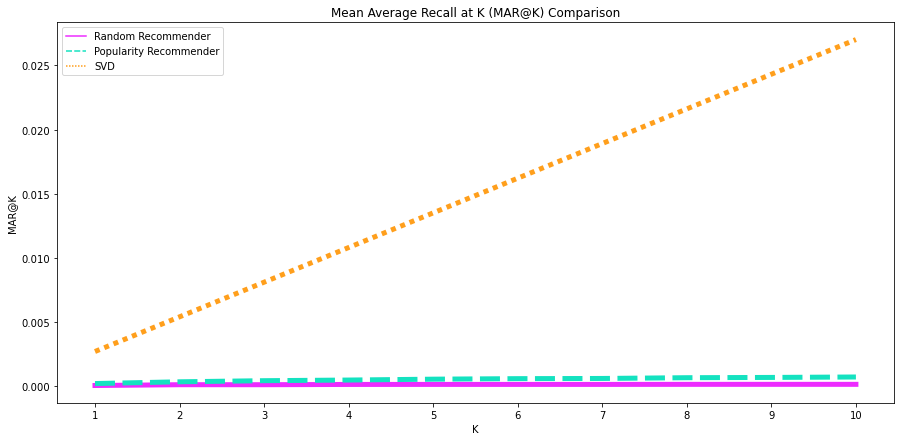

In [25]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'SVD']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [26]:
catalog = ratings.recipe_id.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)

# Catalog Coverage

In [27]:
# N=100 observed recommendation lists
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)
print(cf_cat_coverage)

0.81


# Coverage Plot

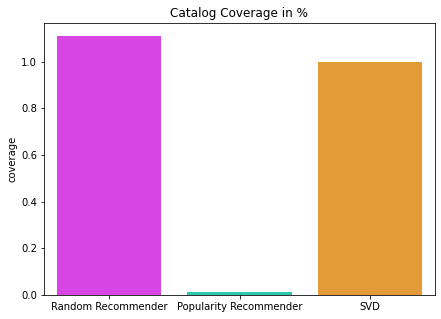

In [28]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'SVD']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Novelty

In [29]:
nov = ratings.recipe_id.value_counts()
pop = dict(nov)

In [30]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)

In [31]:
print(random_novelty, pop_novelty, cf_novelty)

5.020376575304944 1.7457934751039947 3.83464079202079


# Personalization

In [32]:
example_predictions = [
    
[137739, 35397, 482594, 130403, 52424, 139670, 139671],
[43746, 139672, 139677, 139678, 139679, 228704, 52424],
[228704, 384448, 445713, 155165, 115711, 52424, 139671]
]

In [33]:
recmetrics.personalization(predicted=example_predictions)

0.7619047619047622

# Intra-list Similarity

In [34]:
example_predictions = [
    [137739, 139670, 139671],
[111001, 117425, 139671]
]

In [35]:
feature_df = recipes[["'60-minutes-or-less'","'30-minutes-or-less'","'15-minutes-or-less'"]]

In [36]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.16666666666666666

# Classification Probability Plot

In [37]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.641489,1.0
1,0.672276,1.0
2,0.690755,1.0
3,0.771832,1.0
4,0.635667,1.0


/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


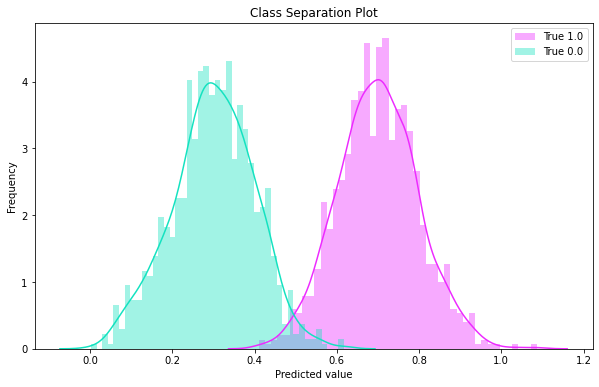

In [38]:
recmetrics.class_separation_plot(pred_df, n_bins=45, title="Class Separation Plot")

# ROC Plot

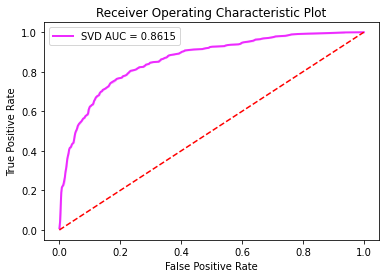

In [39]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="SVD",  figsize=(10, 5))

# Precision Recall Curve

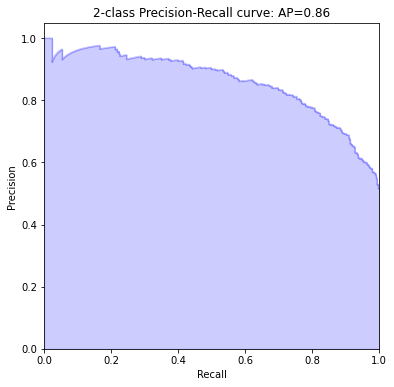

In [40]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)

In [41]:
recmetrics.metrics_plot(model_names=['Model A', 'Model B', 'Model C'],
             coverage_scores=[0.17, 0.25, 0.76],
             personalization_scores=[0.43, 0.23, 0.44],
             intra_list_similarity_scores = [0.23, 0.21, 0.69])

## Create Metrics Plot

Plot the coverage, personalization, and intra-list similarity for a set of models to compare.

In [42]:
recmetrics.metrics_plot(model_names=['KNN', 'SVD', 'THURSDAY'],
             coverage_scores=[0.82, 0.76, 100],
             personalization_scores=[1.00, 1.00, 0.7619047619047622],
             intra_list_similarity_scores = [0.19523809523809524, 0.19047619047619047, 0.16666666666666666])